In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import copy
import sys, time
from torch.autograd import Variable

In [3]:
torch.__version__

'1.13.1+cu116'

# Data

In [4]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_valid = X_train[40000:]
X_train = X_train[:40000]
y_valid = y_train[40000:]
y_train = y_train[:40000]

2024-12-16 23:46:37.460658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 23:46:38.159312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


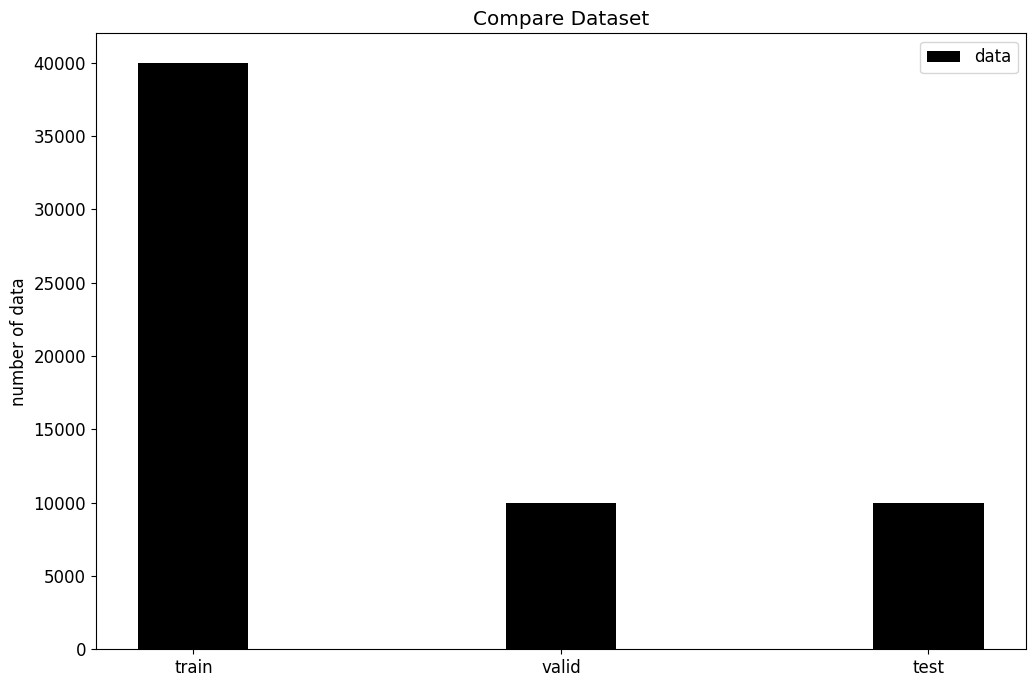

In [5]:
class compare_catdog_dataset():
    def __init__(self, li):
        self.li = li
        self.len_train = len(li[0])
        self.len_valid = len(li[1])
        self.len_test = len(li[2])
    def __call__(self):
        # draw plt
        label = ['train', 'valid', 'test']
        data = [self.len_train, self.len_valid, self.len_test]
        plt.rcParams['font.size'] = 12
        plt.figure(figsize=(12, 8))
        
        x = np.arange(len(label))
        
        plt.bar(x, [self.len_train, self.len_valid, self.len_test], label='data', width=0.3, color='#000')
        plt.legend()
        plt.xticks(x, label)
        plt.ylabel('number of data')
        plt.title('Compare Dataset')
        plt.show()

show = compare_catdog_dataset([X_train, X_valid, X_test])
show()

# Augmentation

In [6]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                       transforms.RandomCrop(32, padding=3),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                     ])

# DataSet

In [7]:
class cifar_Dataset(Dataset):
    def __init__(self, X, y, transform= None):
        self.transform = transform
        self.image_list = X
        self.label_list = y
    
    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.label_list[idx][0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
Trainset = cifar_Dataset(X = X_train, y = y_train, transform = train_transform)
Valset = cifar_Dataset(X = X_valid, y = y_valid, transform = test_transform)
Testset = cifar_Dataset(X = X_test, y = y_test, transform = test_transform)

In [9]:
trainloader = torch.utils.data.DataLoader(Trainset, batch_size=32, shuffle=True, num_workers=1)
Valloader = torch.utils.data.DataLoader(Valset, batch_size=32, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(Testset, batch_size=32, shuffle=False, num_workers=1)

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model

In [11]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    
    def __init(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        
        self.shortcut - nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [14]:
model = ResNet18()
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [26]:
class TrainModel():
    def __init__(self, model, criterion, optimizer, trainloader, testloader, num_epochs=10):
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model = model.to(self.device)
        self.trainloader = trainloader
        self.testloader = testloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.best_acc_wts = copy.deepcopy(self.model.state_dict())
        self.best_acc=0.0
        
        for epoch in range(1, self.num_epochs+1):
            print('Epoch {}/{}'.format(epoch, self.num_epochs))
            self.train()
            self.test()
        
        model.load_state_dict(self.best_acc_wts)
        
    def train(self):
        self.model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets.long())
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.data.cpu().numpy()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 0:
                print('train | Loss: {:.4f} Acc: {:.4f} iter {:d}'.format(loss.data.cpu().numpy(), correct/total, batch_idx))
            
        epoch_loss = train_loss / len(self.trainloader)
        epoch_acc = correct / total
        print('train | Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
    def test(self):
        global best_acc
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.testloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                
                test_loss += loss.data.cpu().numpy()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            epoch_loss = test_loss / len(self.testloader)
            epoch_acc = correct / total
            print('test | Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            if epoch_acc >= self.best_acc:
                self.best_acc = epoch_acc
                self.best_acc_wts = copy.deepcopy(self.model.state_dict())

In [27]:
TrainModel(model, criterion, optimizer, trainloader, testloader, num_epochs=5)

Epoch 1/5
train | Loss: 0.9044 Acc: 0.7188 iter 0.0000
train | Loss: 0.7206 Acc: 0.7757 iter 100.0000
train | Loss: 0.4893 Acc: 0.7704 iter 200.0000
train | Loss: 0.6953 Acc: 0.7687 iter 300.0000
train | Loss: 0.4815 Acc: 0.7717 iter 400.0000
train | Loss: 0.7225 Acc: 0.7724 iter 500.0000
train | Loss: 0.6140 Acc: 0.7743 iter 600.0000
train | Loss: 0.5841 Acc: 0.7758 iter 700.0000
train | Loss: 0.5094 Acc: 0.7761 iter 800.0000
train | Loss: 0.3440 Acc: 0.7762 iter 900.0000
train | Loss: 0.6729 Acc: 0.7765 iter 1000.0000
train | Loss: 0.9971 Acc: 0.7782 iter 1100.0000
train | Loss: 0.8588 Acc: 0.7790 iter 1200.0000
train | Loss: 0.6381 Acc: 0.7801
test | Loss: 0.6030 Acc: 0.7979
Epoch 2/5
train | Loss: 0.3449 Acc: 0.8750 iter 0.0000
train | Loss: 0.4148 Acc: 0.8097 iter 100.0000
train | Loss: 0.3401 Acc: 0.8049 iter 200.0000
train | Loss: 0.5688 Acc: 0.8058 iter 300.0000
train | Loss: 0.5932 Acc: 0.8019 iter 400.0000
train | Loss: 0.4005 Acc: 0.7994 iter 500.0000
train | Loss: 0.6716 Ac

In [16]:
def test(model, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            
            test_loss += loss.data.cpu().numpy()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        epoch_loss = test_loss / len(testloader)
        epoch_acc = correct / total
        print('test | Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

test(model, testloader, criterion)

test | Loss: 2.3037 Acc: 0.1000


In [28]:
test(model, testloader, criterion)

test | Loss: 0.5264 Acc: 0.8280
